<a href="https://colab.research.google.com/github/GaryBall/CSML_notes/blob/master/hgsl_e2e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount the google drive to colab
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [3]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install rdkit
# !pip install hydra-core wandb hydra-core ray ray-lightning torchmetrics overrides imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=cfa77101ed506efd49d819b992e5d1254ffcd428b9481424763277dd8a0eb913
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8

# Synthetic data

In [4]:
import itertools
import random

# Define the nodes
nodes = ['A', 'B', 'C', 'D']

# Generate all binary combinations
combinations = list(itertools.combinations_with_replacement(nodes, 2))

# Calculate 40% of the total combinations
sample_size = round(len(combinations) * 0.4)

# Randomly sample a subset of the combinations
subset = random.sample(combinations, sample_size)

# Print the results
print("All binary combinations:", combinations)
print("Sampled subset (40%):", subset)


All binary combinations: [('A', 'A'), ('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'B'), ('B', 'C'), ('B', 'D'), ('C', 'C'), ('C', 'D'), ('D', 'D')]
Sampled subset (40%): [('A', 'C'), ('A', 'B'), ('B', 'B'), ('B', 'D')]


# Function for generating Heterogeneous Graphs 

- with Small world assumption - Watts Strogatz Graph

In [240]:
from IPython.terminal.embed import ultratb
import networkx as nx
import random
from collections import deque
from itertools import product
import numpy as np

def ws_graph (n,k,p):
  return nx.watts_strogatz_graph(n, k, p)

def get_available_node_types(current_node, graph, meta_graph):
    if current_node is not None:
      current_node_type = graph.nodes[current_node].get('type')
    else:
      current_node_type = None
    
    # process the case when we randomly select a node to start
    if not current_node_type:
        return list(meta_graph.keys())
    else:
        return list(meta_graph[current_node_type].keys())


def normalize_node_type_prob(available_types, node_type_prob):
    total_prob = sum(node_type_prob[available_types].values())
    node_type_prob_normalized = {}
    for node_type, prob in node_type_prob.items():
      normalized_prob = prob / total_prob
      node_type_prob_normalized[node_type] = normalized_prob

    return node_type_prob_normalized



def generate_heterogeneous_small_world(graph, meta_graph, node_type_prob):
    # Step 1: Generate a Watts-Strogatz graph
    

    # Step 2: Normalize node type probabilities
    node_type_prob_normalized = {node_type: prob / sum(node_type_prob.values()) for node_type, prob in node_type_prob.items()}
    print(node_type_prob_normalized)

    # Step 3: Assign node and edge types using BFS
    visited = set()
    print(graph.nodes())
    current_node = None
    last_node = None

    possible_rel = [(i,j) for i in meta_graph.keys() for j in meta_graph[i].keys()]

    for node in graph.nodes():
        if node not in visited:
            # BFS traversal
            queue = deque([node])
            
            visited.add(node)

            while queue:
                print(queue)
            
                current_node = queue.popleft()
                
                if not graph.nodes[current_node].get('type'):
                  possible_start_type = get_available_node_types(current_node, graph, meta_graph)
                  sample_prob = [node_type_prob_normalized[node_type] for node_type in possible_start_type]
                  node_type = random.choices(possible_start_type, sample_prob, k=1)[0]
                  graph.nodes[current_node]['type'] = node_type

                available_node_types = get_available_node_types(current_node, graph, meta_graph)

                # Assign edge types and add unvisited neighbors to queue
                for neighbor in graph.neighbors(current_node):
                    if neighbor not in visited:
                        # Assign node type
                        if not graph.nodes[neighbor].get('type'):
                            sample_prob = [node_type_prob_normalized[node_type] for node_type in available_node_types]
                            node_type = random.choices(available_node_types, sample_prob, k=1)[0]

                            print(graph.nodes[current_node].get('type'), available_node_types)

                            print("sampled node type for node {vnumber}: {vtype}".format(vnumber = neighbor, vtype = node_type))
                            graph.nodes[neighbor]['type'] = node_type

                        queue.append(neighbor)
                        visited.add(neighbor)

                last_node = current_node
            
    for u, v  in graph.edges():
      if (graph.nodes[u]['type'],graph.nodes[v]['type']) in possible_rel:
        print(u,v, graph.nodes[u]['type'], graph.nodes[v]['type'], meta_graph[graph.nodes[u]['type']][graph.nodes[v]['type']])
        graph.edges[u, v]['type'] = meta_graph[graph.nodes[u]['type']][graph.nodes[v]['type']]
      else:
        print(u,v, graph.nodes[u]['type'], graph.nodes[v]['type'], 'NA')
        graph.edges[u, v]['type'] = 'NA'
    
    return graph

meta_graph = {
    'A': {'C': ('A', 'to', 'C')},
    'B': {'C': ('B', 'to', 'C')},
    'C': {'A': ('A', 'to', 'C'),'B':('B', 'to', 'C'), 'D':('C', 'to', 'D')},
    'D': {'C':('C', 'to', 'D'),'D':('D', 'to', 'D')}
}
node_type_prob = {'A': 1, 'B': 1, 'C': 1, 'D': 1}
num_nodes = 15
graph = ws_graph(num_nodes, 3, 0.5)
hetero_graph = generate_heterogeneous_small_world(graph, meta_graph, node_type_prob)


{'A': 0.25, 'B': 0.25, 'C': 0.25, 'D': 0.25}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
deque([0])
C ['A', 'B', 'D']
sampled node type for node 1: B
deque([1])
B ['C']
sampled node type for node 2: C
deque([2])
C ['A', 'B', 'D']
sampled node type for node 3: A
deque([3])
A ['C']
sampled node type for node 11: C
deque([11])
C ['A', 'B', 'D']
sampled node type for node 10: A
C ['A', 'B', 'D']
sampled node type for node 12: B
deque([10, 12])
deque([12])
B ['C']
sampled node type for node 9: C
deque([9])
C ['A', 'B', 'D']
sampled node type for node 8: A
deque([8])
A ['C']
sampled node type for node 7: C
deque([7])
C ['A', 'B', 'D']
sampled node type for node 6: B
deque([6])
B ['C']
sampled node type for node 5: C
deque([5])
C ['A', 'B', 'D']
sampled node type for node 4: B
C ['A', 'B', 'D']
sampled node type for node 14: D
deque([4, 14])
deque([14])
D ['C', 'D']
sampled node type for node 13: C
deque([13])
0 1 C B ('B', 'to', 'C')
1 2 B C ('B', 'to', 'C')
2 3 C A ('A', 'to', 'C')
3

## Graph_stats

In [241]:
# find unique relation types
def unique_rel(meta_graph):
  unique_elements = set()
  for inner_dict in meta_graph.values():
    for element in inner_dict.values():
      unique_elements.add(element)

  return unique_elements

print(sorted(unique_rel(meta_graph)))

[('A', 'to', 'C'), ('B', 'to', 'C'), ('C', 'to', 'D'), ('D', 'to', 'D')]


$\nabla(f)$

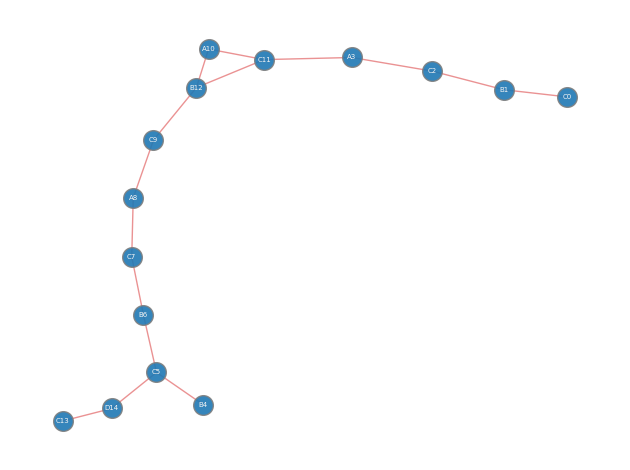

In [242]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(hetero_graph, seed=0)  # positions for all nodes

# nodes
options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
nx.draw_networkx_nodes(hetero_graph, pos, **options)

# edges
nx.draw_networkx_edges(hetero_graph, pos, width=1.0, alpha=0.5, edge_color="tab:red",)

labels = {i: graph.nodes[i]['type']+str(i) for i in range(len(graph.nodes))}
nx.draw_networkx_labels(hetero_graph, pos, labels, font_size=5, font_color="whitesmoke")

plt.tight_layout()
plt.axis("off")     
plt.show()

In [243]:
import itertools

def adjacency_tensor(graph, meta_graph):
    edge_types = sorted(unique_rel(meta_graph))
    # edge_types = ['rel_'+i+j for i,j in itertools.combinations_with_replacement(meta_graph.keys(), 2)]
    print(edge_types)
    n = len(graph.nodes())
    r = len(edge_types)

    adj_matrices = []

    for edge_type in edge_types:
        adj_matrix = np.zeros((n, n), dtype=np.int32)
        
        for u, v, data in graph.edges(data=True):
            if data['type'] == edge_type:
                adj_matrix[u, v] = 1
                adj_matrix[v, u] = 1
        
        adj_matrices.append(adj_matrix)

    edge_dict = {i: edge_types[i] for i in range(len(edge_types))}
    return np.stack(adj_matrices, axis=-1), edge_dict

adj_tsr, edge_dict = adjacency_tensor(hetero_graph, meta_graph)
adj_tsr.shape


[('A', 'to', 'C'), ('B', 'to', 'C'), ('C', 'to', 'D'), ('D', 'to', 'D')]


(15, 15, 4)

In [244]:
edge_dict, meta_graph

({0: ('A', 'to', 'C'),
  1: ('B', 'to', 'C'),
  2: ('C', 'to', 'D'),
  3: ('D', 'to', 'D')},
 {'A': {'C': ('A', 'to', 'C')},
  'B': {'C': ('B', 'to', 'C')},
  'C': {'A': ('A', 'to', 'C'), 'B': ('B', 'to', 'C'), 'D': ('C', 'to', 'D')},
  'D': {'C': ('C', 'to', 'D'), 'D': ('D', 'to', 'D')}})

In [245]:
adj_tsr.shape

(15, 15, 4)

In [246]:
def adj_to_cov(W_GT, num_nodes):
  # W_GT = nx.adjacency_matrix(hetero_graph).todense()
  weights = np.random.lognormal(0, 0.2, (num_nodes, num_nodes))
  weights = (weights + weights.T) / 2
  
  W_GT = W_GT * weights
  W_GT = W_GT * num_nodes / (np.sum(W_GT)+1e-10)
  L_GT = np.diag(W_GT @ np.ones(num_nodes)) - W_GT
  
  cov_GT = np.linalg.inv(L_GT + (1e-1) * np.eye(num_nodes))
  return cov_GT



def generate_rel_signals(adj_tensor, sgl_dim):
  noise_sigma = 1e-02
  num_nodes,_, rel_num = adj_tensor.shape
  print(rel_num)
  emb_dim = sgl_dim * rel_num
  print(emb_dim, sgl_dim)
  signals_nodes = np.random.multivariate_normal(np.zeros(num_nodes), noise_sigma* np.eye(num_nodes), emb_dim)
  signals_edges = np.zeros((rel_num, emb_dim))
  
  for rel in range(rel_num):
    # the dimensions that are specific to relation type
    cov = adj_to_cov(adj_tensor[:,:,rel], num_nodes)
    # signals_rel = np.random.multivariate_normal(np.zeros(num_nodes), cov, sgl_dim)
    # the dimension that is not relevant to relation type
    signals_nodes[sgl_dim*rel:sgl_dim*(rel+1)] += np.random.multivariate_normal(np.zeros(num_nodes), cov, sgl_dim)
    signals_edges[rel, sgl_dim*rel:sgl_dim*(rel+1)] = 1/sgl_dim
  
  return signals_nodes.T, signals_edges




sgl_dim = 100
signal_vtx, signals_edge = generate_rel_signals(adj_tsr, sgl_dim)

4
400 100


In [249]:
import torch
from torch_geometric.data import HeteroData

def get_edge_idx(n_id, n_id_ori, edge_idx):
  # Expand B to have the same shape as (C.size(0), B.size(0))
  expanded_ori = n_id_ori.expand(edge_idx.shape[0], -1)
  # Compute a mask where each row corresponds to the comparison of C[i] with B
  mask = (expanded_ori == edge_idx.unsqueeze(1))
  # Get the index in A by using the computed mask
  # The method `max` is used to get the last occurrence, replace it with `min` for the first occurrence
  # Use the indices to get the corresponding elements from A
  _, indices = mask.max(dim=1)
  return n_id[indices]


def generate_hetero_sgls(hetero_graph, meta_graph, adj_tensor, sgl_dim, output_dim):
  edge_types = sorted(unique_rel(meta_graph))
  noise_sigma = 1e-02
  num_nodes,_ ,rel_num = adj_tensor.shape
  print(rel_num)
  emb_dim = sgl_dim * rel_num
  print(emb_dim, sgl_dim)
  signals_nodes = np.random.multivariate_normal(np.zeros(num_nodes), noise_sigma* np.eye(num_nodes), emb_dim)

  
  signals_edges = np.zeros((rel_num, emb_dim))
  
  for i in range(len(edge_types)):
    # the dimensions that are specific to relation type
    cov = adj_to_cov(adj_tensor[:,:,i], num_nodes)
    # signals_rel = np.random.multivariate_normal(np.zeros(num_nodes), cov, sgl_dim)
    # the dimension that is not relevant to relation type
    signals_nodes[sgl_dim*i:sgl_dim*(i+1)] += np.random.multivariate_normal(np.zeros(num_nodes), cov, sgl_dim)
    signals_edges[i, sgl_dim*i:sgl_dim*(i+1)] = 1/sgl_dim
  
  signals_nodes = torch.Tensor(signals_nodes)
  graph_pyg = HeteroData()
  trans_matrix = torch.rand(signals_nodes.shape[-1], output_dim)

  for node_type in meta_graph:
    node_idxs = [node_idx for node_idx in hetero_graph.nodes if node_type == hetero_graph.nodes[node_idx]['type']]
    graph_pyg[node_type].x  = signals_nodes[node_idxs] @ trans_matrix
    graph_pyg[node_type].n_id_ori = torch.Tensor(node_idxs).int()
    graph_pyg[node_type].n_id = torch.Tensor(range(len(graph_pyg[node_type].n_id_ori))).int()
  
  for i, j in itertools.combinations_with_replacement(meta_graph.keys(), 2):
    if (i, 'to', j) in edge_types:
      print('rel_'+i+j)
      edge_type_idx = edge_types.index((i, 'to', j))
      non_zeros = torch.tensor(adj_tensor)[:,:,edge_type_idx].nonzero().T
      mask = torch.isin(non_zeros[0, :], graph_pyg[i].n_id_ori)
      print(non_zeros[:, mask])

      s_idx = get_edge_idx(graph_pyg[i].n_id, graph_pyg[i].n_id_ori, non_zeros[:, mask][0])
      t_idx = get_edge_idx(graph_pyg[j].n_id, graph_pyg[j].n_id_ori, non_zeros[:, mask][1])
      print(torch.stack((s_idx, t_idx), dim=0))

      graph_pyg[(i, 'to', j)].edge_index = torch.stack((s_idx, t_idx), dim=0)
  
  edge_onehot = torch.eye(len(graph_pyg.edge_types))

  i=0
  for edge_type in graph_pyg.edge_types:
    graph_pyg[edge_type].x = edge_onehot[i].reshape(1,-1)
    i+=1


  return graph_pyg

data = generate_hetero_sgls(hetero_graph, meta_graph, adj_tsr, sgl_dim, output_dim = 100)

4
400 100
rel_AC
tensor([[ 3,  3,  8,  8, 10],
        [ 2, 11,  7,  9, 11]])
tensor([[0, 0, 1, 1, 2],
        [1, 5, 3, 4, 5]], dtype=torch.int32)
rel_BC
tensor([[ 1,  1,  4,  6,  6, 12, 12],
        [ 0,  2,  5,  5,  7,  9, 11]])
tensor([[0, 0, 1, 2, 2, 3, 3],
        [0, 1, 2, 2, 3, 4, 5]], dtype=torch.int32)
rel_CD
tensor([[ 5, 13],
        [14, 14]])
tensor([[2, 6],
        [0, 0]], dtype=torch.int32)
rel_DD
tensor([], size=(2, 0), dtype=torch.int64)
tensor([], size=(2, 0), dtype=torch.int32)


In [399]:
data['D']

{'x': tensor([[ 3.6991,  7.5822,  9.7906,  5.4923,  5.8905,  5.7355,  4.9892,  8.2958,
          3.0284,  6.0156,  0.9729,  7.9009,  5.0206,  6.7804,  3.6630, 10.6558,
          3.7842, -0.5147,  8.4176, -3.2667,  3.2054, -0.9291,  5.7305,  6.4572,
          3.7055,  9.0545,  6.6750,  3.4784,  8.7374,  4.1874,  4.7241,  3.9080,
          2.6208,  8.3157,  1.2000,  5.3513,  2.3079,  5.4160,  0.7103,  0.7952,
          1.8397,  6.2756,  0.0647, 10.2602,  0.8520,  0.6558,  7.4690,  4.4765,
          0.7712,  2.3049, -0.9029,  1.1872,  6.4782,  7.5953,  3.1303,  2.2345,
          3.4018,  3.5369,  7.2633,  0.5647,  3.1622,  4.6396,  9.8936,  5.8729,
          6.2661,  2.5476,  1.1603, 10.7901,  5.4626, -1.0924,  6.5631,  6.3952,
          5.0452,  9.8019,  1.9856,  0.3741,  3.7823,  6.2954,  4.7528,  0.9537,
          7.9782,  3.5944,  9.5754,  6.5056,  4.4423,  7.9705,  3.3248,  3.0347,
          2.7748,  6.9532,  0.7307,  7.5953,  0.4325,  3.4124,  3.5306,  5.3932,
          4.1110,  5.7

In [261]:
import math
import scipy.sparse as sparse

def coo_to_sparseTensor(coo):
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

def get_degree_operator(m):
  
    ncols =int(m*(m - 1)/2)

    I = np.zeros(ncols)
    J = np.zeros(ncols)

    k = 0
    for i in np.arange(1, m):
        I[k:(k + m - i)] = np.arange(i, m)
        k = k + (m - i)

    k = 0
    for i in np.arange(1, m):
        J[k: (k + m - i)] = i - 1
        k = k + m - i

    Row = np.tile(np.arange(0, ncols), 2)
    Col = np.append(I, J)
    Data = np.ones(Col.size)
    St = sparse.coo_matrix((Data, (Row, Col)), shape=(ncols, m))
    return St.T

In [528]:
import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, HeteroDictLinear

class LinearProj(torch.nn.Module):
    def __init__(self, node_shape, edge_shape, out_channels):
        super().__init__()
        self.NodeLinear = HeteroDictLinear(in_channels=node_shape,out_channels=out_channels)
        self.EdgeLinear = Linear(edge_shape[0],out_channels)

    def forward(self, batch):
      node_attrs = {node_type: batch[node_type].x for node_type in batch.node_types}

      node_out = self.NodeLinear(node_attrs)
      edge_out = {edge_type: self.EdgeLinear(batch[edge_type].x) for edge_type in batch.edge_types}
      
      for node_type in batch.node_types:
        node_out[node_type] = node_out[node_type]/(node_out[node_type].norm(dim=1)[:, None])
      for edge_type in batch.edge_types:
        edge_out[edge_type] = edge_out[edge_type]/(edge_out[edge_type].norm(dim=1)[:, None])

      return (node_out, edge_out)


class Model(torch.nn.Module):
    def __init__(self, node_shape, edge_shape, w_l, D, out_channels=100):
        super().__init__()
        
        self.out_channels = out_channels
        self.w = torch.nn.Parameter(torch.rand(w_l))
        self.D = D
        self.hetero_linear = LinearProj(node_shape, edge_shape, out_channels=out_channels)
        self.classifier = Classifier()
        

    def forward(self, batch, device):

        # D is the degree operator

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        node_out, edge_out = self.hetero_linear(batch)
        pred_list = []
        m = batch.num_nodes
        r = len(batch.edge_types)
        batch_size = 1
        n_emb = torch.zeros(m, self.out_channels).to(device)
        
        for n_type in batch.node_types:
          n_emb[batch[n_type].n_id_ori] = node_out[n_type]
          # print('node_out shape',node_out[n_type].shape)
          # print(batch[n_type].n_id)
        r_emb = [edge_out[r_type] for r_type in sorted(batch.edge_types)]
        r_emb = torch.cat(r_emb, dim=0)
        
        diff_tensor = (n_emb[:, None, None, :] - n_emb[None,: , None, :]) * r_emb[ None, None, :, :]
        # print(r_emb.shape)
        # print(n_emb.shape)
        # print('n_emb', torch.max(torch.abs(n_emb)))
        # print('r_emb',torch.max(torch.abs(r_emb)))
        sigma = 1e-3
        smooth_tensor = torch.exp(-1/sigma * torch.norm(diff_tensor, dim=-1)**2)
        smooth_tensor = smooth_tensor.unsqueeze(0)
        mask = torch.triu(torch.ones(m, m), diagonal=1).bool()
        z = smooth_tensor[:, mask].view(batch_size, -1)

        return self.w.view(1,-1), z



In [533]:
from torch.nn.utils import clip_grad_norm_

def objective(w, D, z, l2_penalty=0.01, log_penalty=0.1):
  alpha = log_penalty
  beta = l2_penalty 

  w = F.relu(w)
  
  f1 = beta * torch.norm(w, 2) ** 2
  f2 = 1e4 * w @ z.T
  f3 = - alpha * torch.sum(torch.log(w@D.T))
  print(f1,f2[0][0],f3)

  if torch.all(w.ge(0)) >= 0:
    return f1 + f2[0][0] + f3
  else:
    return 10**3


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

node_shape = {node_type: data[node_type].x.shape[-1] for node_type in data.node_types}
edge_shape = [data[edge_type].x.shape[-1] for edge_type in data.edge_types]

w_l = int(data.num_nodes*(data.num_nodes-1)*len(data.edge_types)/2)
D_ori = coo_to_sparseTensor(get_degree_operator(data.num_nodes)).to(device)
eye = torch.eye(int(data.num_nodes*(data.num_nodes-1)/2))
shift_sum = eye.repeat_interleave(len(data.edge_types), dim=1)
D = D_ori @ shift_sum.to(device)

model = Model(node_shape, edge_shape, w_l, D, out_channels=100)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
data = data.to(device)
model = model.to(device)

for epoch in range(1, 501):
  model.train()
  optimizer.zero_grad()
  loss = 0
  w, z = model(data, device)
  loss = objective(w=w.to(device), D=D.to(device), z=z.to(device))
  print(loss)
  loss.backward()
  clip_grad_norm_(model.parameters(), 5)
  optimizer.step()

  print('loss: {}, epoch: {}'.format(loss, epoch))

tensor(1.2741, device='cuda:0', grad_fn=<MulBackward0>) tensor(8077.4800, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-4.9185, device='cuda:0', grad_fn=<MulBackward0>)
tensor(8073.8354, device='cuda:0', grad_fn=<AddBackward0>)
loss: 8073.83544921875, epoch: 1
tensor(1.2701, device='cuda:0', grad_fn=<MulBackward0>) tensor(4125.9141, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-4.9153, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4122.2690, device='cuda:0', grad_fn=<AddBackward0>)
loss: 4122.26904296875, epoch: 2
tensor(1.2661, device='cuda:0', grad_fn=<MulBackward0>) tensor(1667.5687, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-4.9121, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1663.9227, device='cuda:0', grad_fn=<AddBackward0>)
loss: 1663.9227294921875, epoch: 3
tensor(1.2621, device='cuda:0', grad_fn=<MulBackward0>) tensor(473.0529, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-4.9089, device='cuda:0', grad_fn=<MulBackward0>)
tensor(469.4061, device

In [534]:
mask = torch.triu(torch.ones(data.num_nodes, data.num_nodes), diagonal=1).bool()
adj_vec = torch.Tensor(adj_tsr).unsqueeze(0)[:,mask].view(1, -1)

In [535]:
adj_vec

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [536]:
F.relu(w)

tensor([[0.3115, 0.1288, 0.5070, 0.5559, 0.1270, 0.1224, 0.1250, 0.1222, 0.3443,
         0.1311, 0.1707, 0.1298, 0.1978, 0.1249, 0.1529, 0.1226, 0.2628, 0.2759,
         0.1241, 0.2341, 0.1568, 0.1437, 0.3054, 0.1462, 0.3312, 0.1446, 0.1450,
         0.1855, 0.1319, 0.5599, 0.1320, 0.3407, 0.1326, 0.1262, 0.2305, 0.2552,
         0.1911, 0.1561, 0.1308, 0.1537, 0.2806, 0.5156, 0.1398, 0.2171, 0.2288,
         0.1882, 0.1262, 0.1324, 0.2327, 0.1188, 0.4478, 0.1239, 0.2950, 0.1232,
         0.2349, 0.4774, 0.2337, 0.2186, 0.3147, 0.1253, 0.1260, 0.1499, 0.1712,
         0.3245, 0.1148, 0.1127, 0.1198, 0.1207, 0.5143, 0.3894, 0.1734, 0.2191,
         0.4654, 0.1149, 0.1216, 0.1187, 0.1219, 0.1236, 0.4694, 0.1277, 0.1210,
         0.5324, 0.1225, 0.1266, 0.3276, 0.5593, 0.4193, 0.1857, 0.1241, 0.1789,
         0.1457, 0.1250, 0.1282, 0.1327, 0.3317, 0.1272, 0.1262, 0.2098, 0.1425,
         0.2429, 0.2874, 0.1211, 0.3407, 0.4708, 0.1184, 0.4616, 0.4134, 0.1198,
         0.1204, 0.2042, 0.1

## From signal estimate Laplacian Matrix

In [ ]:
class ADMM():
    def __init__(self, l2_penalty, log_penalty, step_size=1e-02, relaxation_factor = 1.8):
        self.alpha = log_penalty  # the penalty before log barrier
        self.beta = l2_penalty  # the penalty before l2 term
        self.gn = step_size
        self.relax = relaxation_factor

    def initialisation(self, l, m, batch_size=1):
        w = torch.zeros((batch_size, l)).float().to(device)
        v = torch.zeros((batch_size, m)).float().to(device)
        return w, v

    def prox_log_barrier(self, y, gn, alpha):
        up = y ** 2 + 4 * gn * alpha
        up = torch.clamp(up, 1e-08)
        return (y - torch.sqrt(up)) / 2

    def objective(self, w, D, z):
        f1 = self.beta * torch.norm(w, 2) ** 2
        f2 = w.T @ z
        f3 = - self.alpha * torch.sum(torch.log(D @ w))

        if all(np.round(w, 4) >= 0):
            return f1 + f2 + f3
        else:
            return 10**3

    def solve(self, smooth, max_iter=1000, verbose=True):
        batch_size, m, _, r = smooth.shape
        mask = torch.triu(torch.ones(m, m), diagonal=1).bool()
        z = smooth[:, mask].view(batch_size, -1)
        l = int(m*(m-1)*r/2)

        D_ori = coo_to_sparseTensor(get_degree_operator(m)).to(device)
        eye = torch.eye(int(m*(m-1)/2))
        shift_sum = eye.repeat_interleave(r, dim=1)
        D = D_ori @ shift_sum.to(device)

        # D * shift_sum if the new operator

        # initialise:
        w, v = self.initialisation(l, m, batch_size)
        zero_vec = torch.zeros((batch_size, l)).to(device)
        # w_list = torch.empty(size=(batch_size, max_ite, l))
        # print(w_list.shape)

        lambda_ = self.relax

        for i in range(max_iter):

            y1 = w - self.gn * (2 * self.beta * w + torch.matmul(v, D))
            p1 = torch.max(zero_vec, y1 - 2 * self.gn * z)

            y2 = v + self.gn * torch.matmul(2 * p1 - w, D.T)
            p2 = self.prox_log_barrier(y2, self.gn, self.alpha)

            w = w + lambda_ * (p1 - w)
            v = v + lambda_ * (p2 - v)

            # w_list[:, i, :] = w

        return w

#%%

class PDS():
    def __init__(self, l2_psi, log_psi, step_size):
        self.alpha = log_psi  # the penalty before log barrier
        self.beta = l2_psi  # the penalty before l2 term
        self.gn = step_size

    def prox_log_barrier(self, y, gn, alpha):
        return (y - torch.sqrt(y ** 2 + 4 * gn * alpha)) / 2

    def initialisation(self, l, m, batch_size):
        w = torch.zeros((batch_size, l)).float().to(device)
        v = torch.zeros((batch_size, m)).float().to(device)
        return w, v

    def solve(self, smooth, max_iter = 500):
        # z \in 1* m* m * r
        batch_size, m, _, r = smooth.shape
        mask = torch.triu(torch.ones(m, m), diagonal=1).bool()
        z = smooth[:, mask].view(batch_size, -1)
        l = int(m*(m-1)*r/2)

        D_ori = coo_to_sparseTensor(get_degree_operator(m)).to(device)
        eye = torch.eye(int(m*(m-1)/2))
        shift_sum = eye.repeat_interleave(r, dim=1)
        D = D_ori @ shift_sum.to(device)

        # initialise:
        w, v = self.initialisation(l, m, batch_size)
        zero_vec = torch.zeros((batch_size, l)).to(device)
        # w_list = torch.empty(size=(batch_size, max_iter, l)).to(device)
        for i in range(max_iter):
            # print(z.shape)
            y1 = w - self.gn * (2 * self.beta * w + 2 * z + torch.matmul(v, D))
            y2 = v + self.gn * torch.matmul(w, D.T)

            p1 = torch.max(zero_vec, y1)
            p2 = self.prox_log_barrier(y2, self.gn, self.alpha)

            q1 = p1 - self.gn * (2 * self.beta * p1 + 2 * z + torch.matmul(p2, D))
            q2 = p2 + self.gn * torch.matmul(p1, D.T)

            w = w - y1 + q1
            v = v - y2 + q2

            # w_list[:, i, :] = w

        return w


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
def auc_test(model, loader, device):
  preds = []
  ground_truths = []
  model.to(device)
  model.eval()
  for test_batch in tqdm.tqdm(loader):
      test_batch = test_batch.to(device)
      preds.append(model(test_batch))
      with torch.no_grad():
        for edge_type in test_batch.edge_types:
          ground_truths.append(test_batch[edge_type].edge_label)
  pred = torch.cat(preds, dim=0).cpu().detach().numpy()
  # pred = pred/np.max(pred)
  ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
  auc = roc_auc_score(ground_truth, pred)
  f1 = f1_score(ground_truth, (pred>0.5))
  return auc, f1

In [ ]:
pds_opt = PDS(1, 1, 1e-2)

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

def estimate_w(signal_vtx, signals_edge, adj_tensor, optimizer):
  diff_tensor = (signal_vtx[:, None, None, :] - signal_vtx[None,: , None, :]) * signals_edge[ None, None, :, :]
  diff_tensor = torch.Tensor(diff_tensor)
  num_nodes,_,num_relations ,K = diff_tensor.shape
  smooth_tensor = torch.norm(diff_tensor, dim=-1)**2
  # est_tensor = torch.exp(- 1/sigma * smooth_tensor)
  adj_tensor = torch.Tensor(adj_tensor).unsqueeze(0).to(device)
  mask = torch.triu(torch.ones(num_nodes, num_nodes), diagonal=1).bool()
  adj_vec = adj_tensor[:, mask].view(1, -1)
  print(smooth_tensor.shape)
  w = optimizer.solve(smooth_tensor.unsqueeze(0).to(device), max_iter = 500)
  # Normalization
  w = w/torch.max(w)
  GMSE_error = torch.sum(torch.square(w-adj_vec)/(w+1e-12))

  num_samples = w.shape[0] * w.shape[1]*w.shape[0]
  edge_indices = torch.where(adj_vec == 1)
  # Use these indices to access the corresponding elements in B
  out_edges = w[edge_indices]
  print(adj_vec[edge_indices])
  print(w)
  print(out_edges)
  link_error = torch.mean(torch.square(adj_vec[edge_indices] - out_edges))
  print(GMSE_error/num_samples)
  print(torch.sqrt(link_error))
  auc = roc_auc_score(adj_vec.to('cpu')[0], w.to('cpu')[0])
  f1 = f1_score(adj_vec.to('cpu')[0], (w>0.8).to('cpu')[0])
  print(auc, f1)
  # auc = roc_auc_score(adj_vec[edge_indices].to('cpu').detach().numpy(), out_edge


estimate_w(signal_vtx, signals_edge, adj_tsr, pds_opt)

In [ ]:
admm_opt = ADMM(l2_penalty=2, log_penalty=1, step_size=1e-02, relaxation_factor = 1.8)
estimate_w(signal_vtx, signals_edge, adj_tsr, admm_opt)

torch.Size([50, 50, 15])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[ 9.3078e-02, -2.9427e-44,  5.7762e-02,  ..., -2.9427e-44,
          1.6641e-01,  9.5891e-02]], device='cuda:0')
tensor([0.9519, 0.8509, 0.8758, 0.9388, 1.0000, 0.8812, 0.9650, 0.9385, 0.9189,
        0.8664, 0.8285, 0.8937, 0.8985, 0.9194, 0.9301, 0.9270, 0.9160, 0.9065,
        0.8700, 0.9062, 0.9256, 0.9198, 0.8712, 0.9219, 0.9439, 0.8959, 0.9051,
        0.8782, 0.8873, 0.9201, 0.9253, 0.9095, 0.8782, 0.8949, 0.9091, 0.9214,
        0.8798, 0.8581, 0.9152, 0.9520, 0.9108, 0.8998, 0.9200, 0.9185, 0.8673,
        0.8894, 0.9047, 0.9358, 0.9261, 0.9774], device='cuda:0')
tensor(0.0736, device='cuda:0')
tensor(0.0966, device='cuda:0')
0.999587448840382


# Graph Sampling from huge heterogeneous graph

Loading graphs

In [ ]:
from torch_geometric.datasets import DBLP

dataset_dblp = DBLP(root='./data/dblp')
data = dataset_dblp[0]

Extracting data/dblp/raw/DBLP_processed.zip
Processing...
Done!


## Link Prediction

In [ ]:
from numpy.random.mtrand import noncentral_chisquare
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import HGTLoader

def data_preprocessing(data):
  # node type processing
  # for node_type in data.node_types:
  #   if data[node_type].x is None:
  data['conference'].x = torch.eye(data['conference'].num_nodes)

  # edge type processing
  edge_onehot = torch.eye(len(data.edge_types))
  i=0
  for edge_type in data.edge_types:
    data[edge_type].x = edge_onehot[i].reshape(1,-1)
    i+=1
  return data

def data_spliting(data):
  transform = RandomLinkSplit(num_val=0.3, num_test=0.2, 
                            is_undirected=True,
                            neg_sampling_ratio=1.0,
                            add_negative_train_samples=True,
                            edge_types=data.edge_types)
  train_test_split = transform(data)
  data_list = []
  for b_data in train_test_split:
    b_data.generate_ids()
    
    for edge_type in b_data.edge_types:
      b_data[edge_type].e_id = torch.arange(len(b_data[edge_type].edge_label))
      b_data[edge_type].edge_index = b_data[edge_type].edge_label_index
      del b_data[edge_type].edge_label_index
    data_list.append(b_data)
  
  return data_list

def data_batching(data, batch_size, input_nodes):
    loader = HGTLoader(
    data,
    # Sample 512 nodes per type and per iteration for 4 iterations
    num_samples={key: [8] * 4 for key in data.node_types},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size = batch_size,
    input_nodes=input_nodes,
    )
    return loader


data = data_preprocessing(data)
train_data, val_data, test_data = data_spliting(data)
train_loader = data_batching(train_data, 8, ('paper'))
val_loader = data_batching(val_data, 8, ('paper'))
test_loader = data_batching(test_data, 4, ('paper'))

In [ ]:
batch = next(iter(train_loader))
batch

HeteroData(
  author={
    x=[29, 334],
    y=[29],
    train_mask=[29],
    val_mask=[29],
    test_mask=[29],
    n_id=[29]
  },
  paper={
    x=[32, 4231],
    n_id=[32],
    input_id=[8],
    batch_size=8
  },
  term={
    x=[32, 50],
    n_id=[32]
  },
  conference={
    num_nodes=10,
    x=[10, 20],
    n_id=[10]
  },
  (author, to, paper)={
    edge_index=[2, 31],
    x=[1, 6],
    edge_label=[31],
    e_id=[31]
  },
  (paper, to, author)={
    edge_index=[2, 19],
    x=[1, 6],
    edge_label=[19],
    e_id=[19]
  },
  (paper, to, term)={
    edge_index=[2, 16],
    x=[1, 6],
    edge_label=[16],
    e_id=[16]
  },
  (paper, to, conference)={
    edge_index=[2, 0],
    x=[1, 6],
    edge_label=[0],
    e_id=[0]
  },
  (term, to, paper)={
    edge_index=[2, 34],
    x=[1, 6],
    edge_label=[34],
    e_id=[34]
  },
  (conference, to, paper)={
    edge_index=[2, 21],
    x=[1, 6],
    edge_label=[21],
    e_id=[21]
  }
)

In [ ]:
for edge_type in train_data.edge_types:
  print(train_data[edge_type].edge_label.shape)
for edge_type in train_data.edge_types:
  print(train_data[edge_type].edge_index.shape)

torch.Size([19646])
torch.Size([19646])
torch.Size([85810])
torch.Size([14330])
torch.Size([85810])
torch.Size([14330])
torch.Size([2, 19646])
torch.Size([2, 19646])
torch.Size([2, 85810])
torch.Size([2, 14330])
torch.Size([2, 85810])
torch.Size([2, 14330])


In [ ]:
def get_complete_subgraph(subgraph, graph):
  for edge_type in subgraph.edge_types:
    # assuming edge_index is your edge index tensor with shape [2, E]
    # and sampled_nodes is your tensor of node indices to include in the subgraph

    # get the start and end nodes for each edge
    s_ntype, _, t_ntype = edge_type
    s_mapping = {old_id: new_id for new_id, old_id in enumerate(subgraph[s_ntype].n_id.tolist())}
    t_mapping = {old_id: new_id for new_id, old_id in enumerate(subgraph[t_ntype].n_id.tolist())}

    s_nodes, t_nodes = graph[edge_type].edge_index

    # find the indices of the edges where both the start node and end node are in sampled_nodes
    mask = (torch.isin(s_nodes, subgraph[s_ntype].n_id) & torch.isin(t_nodes, subgraph[t_ntype].n_id))
    print(mask.shape)

    # subset the edge index tensor to include only these edges
    subgraph_edge_index = graph[edge_type].edge_index[:, mask]
    s_idx, t_idx = subgraph_edge_index
    new_s_nodes = torch.tensor([s_mapping[node.item()] for node in s_idx])
    new_e_nodes = torch.tensor([t_mapping[node.item()] for node in t_idx])

    # create a new edge index tensor with the re-indexed node IDs
    subgraph[edge_type].edge_index = torch.stack([new_s_nodes, new_e_nodes])
    subgraph[edge_type].edge_label = graph[edge_type].edge_label[mask]
    subgraph[edge_type].e_id = graph[edge_type].e_id[mask]
  
  return subgraph

for batch in test_loader:
  batch = get_complete_subgraph(batch, train_data)



In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, HeteroDictLinear

class NodeLinProj(torch.nn.Module):
    def __init__(self, node_shape, out_channels):
        super().__init__()
        self.NodeLinear = HeteroDictLinear(in_channels=node_shape,out_channels=out_channels)
        self.EdgeLinear = Linear(in_features=edge_shape, out_features=out_channels)
        

    def forward(self, batch):
      node_attrs = {node_type: batch[node_type].x for node_type in batch.node_types}
      edge_attrs = {'_'.join(edge_type): batch[edge_type].x for edge_type in batch.edge_types}

      node_out = self.NodeLinear(node_attrs)
      edge_out = {'_'.join(edge_type): self.EdgeLinear(batch[edge_type].x) for edge_type in batch.edge_types}(edge_attrs)
      
      for node_type in batch.node_types:
        node_out[node_type] = node_out[node_type]/(node_out[node_type].norm(dim=1)[:, None])
      for edge_type in edge_attrs:
        edge_out[edge_type] = edge_out[edge_type]/(edge_out[edge_type].norm(dim=1)[:, None]) 

      return (node_out, edge_out)

class EdgeLinProj(torch.nn.Module):
  def __init__(self, edge_shape, out_channels):
    self.EdgeLinear = Linear(in_features=edge_shape, out_features=out_channels)
  
  def forward(self, batch):
    edge_attrs = {'_'.join(edge_type): batch[edge_type].x for edge_type in batch.edge_types}


class Classifier(torch.nn.Module):
    def forward(self, s_node_x, t_node_x ,r_emb, edge_index):
        sigma = 1e-3
        s_idx, t_idx = edge_index[0], edge_index[1]
        s_nemb, t_nemb = s_node_x[s_idx], t_node_x[t_idx]
        diff_vector = r_emb * (s_nemb - t_nemb)
        smooth = torch.exp(- 1/sigma * torch.norm(diff_vector, dim=-1)**2)
        # print(diff_vector.shape, torch.norm(diff_vector, dim=-1).shape)
        # print(torch.norm(diff_vector, dim=-1)**2)
        # smooth = torch.exp(-1/sigma* (torch.norm(diff_vector, dim=-1)))
        
        return smooth


class Model(torch.nn.Module):
    def __init__(self, node_shape, edge_shape, out_channels=100):
        super().__init__()
        self.hetero_linear = LinearProj(node_shape, edge_shape, out_channels=100)
        self.classifier = Classifier()

    def forward(self, batch):

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        node_out, edge_out = self.hetero_linear(batch)
        pred_list = []
        for edge_type in batch.edge_types:
          s_ntype, _, t_ntype = edge_type
          s_emb, t_emb = node_out[s_ntype], node_out[t_ntype]
          r_emb = edge_out['_'.join(edge_type)]
          # print(self.classifier(s_emb, t_emb, r_emb, batch[edge_type].edge_index).shape)
          # print('gt: {}'.format(batch[edge_type].edge_label))
          # print('pred:{}'.format(self.classifier(s_emb, t_emb, r_emb, batch[edge_type].edge_index)))
          pred_list += [self.classifier(s_emb, t_emb, r_emb, batch[edge_type].edge_index)]
        pred = torch.cat(pred_list)
        return pred

In [ ]:
node_shape = {node_type: train_data[node_type].x.shape[-1] for node_type in train_data.node_types}
# edge_shape = {'_'.join(edge_type): train_data[edge_type].x.shape[-1] for edge_type in train_data.edge_types}
edge_shape = train_data[edge_type].x.shape[-1]

model = Model(node_shape, edge_shape, out_channels=500)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
def auc_test(mode, loader, device):
  preds = []
  ground_truths = []
  model.to(device)
  model.eval()
  for test_batch in tqdm.tqdm(loader):
      test_batch = test_batch.to(device)
      preds.append(model(test_batch))
      with torch.no_grad():
        for edge_type in test_batch.edge_types:
          ground_truths.append(test_batch[edge_type].edge_label)
  pred = torch.cat(preds, dim=0).cpu().detach().numpy()
  pred = pred/np.max(pred)
  ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
  auc = roc_auc_score(ground_truth, pred)
  f1 = f1_score(ground_truth, (pred>0.5))
  return auc, f1

In [ ]:
import tqdm
import torch.nn.functional as F
from torch_geometric.loader import HGTLoader
from torch_geometric.loader import LinkNeighborLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: '{device}'")
model = model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
scheduler = CosineAnnealingWarmRestarts(optimizer, 
                                        T_0 = 8,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-5) # Minimum learning rate
# Adam best learning rate: 1e-2, sigma= 1e-3, weight decay = 0
# SGD best learning rate: 1e-3, decay = 0.1, no sigma


for epoch in range(1, 21):
    total_loss = total_examples = 0
    for batch in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        pred = model(batch)
        
        gt_list = []
        for edge_type in batch.edge_types:
          gt_list.append(batch[edge_type].edge_label)
        ground_truth = torch.cat(gt_list)
        loss = F.binary_cross_entropy(pred, ground_truth, reduction='mean')
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    scheduler.step()
    
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}, learning_rate: {get_lr(optimizer):.4f}")
    if epoch % 10 == 0:
      auc_result, f1_sco = auc_test(model,val_loader, device)
      print(f"AUC: {auc_result:.4f}, f1 score: {f1_sco:.4f}")



Device: 'cuda:0'


100%|██████████| 1791/1791 [00:32<00:00, 55.96it/s]


Epoch: 001, Loss: 0.2719, learning_rate: 0.0096


100%|██████████| 1791/1791 [00:29<00:00, 60.90it/s]


Epoch: 002, Loss: 0.2668, learning_rate: 0.0085


100%|██████████| 1791/1791 [00:29<00:00, 59.85it/s]


Epoch: 003, Loss: 0.2626, learning_rate: 0.0069


100%|██████████| 1791/1791 [00:30<00:00, 58.22it/s]


Epoch: 004, Loss: 0.2570, learning_rate: 0.0050


100%|██████████| 1791/1791 [00:29<00:00, 61.27it/s]


Epoch: 005, Loss: 0.2516, learning_rate: 0.0031


100%|██████████| 1791/1791 [00:29<00:00, 61.23it/s]


Epoch: 006, Loss: 0.2465, learning_rate: 0.0015


100%|██████████| 1791/1791 [00:29<00:00, 61.40it/s]


Epoch: 007, Loss: 0.2434, learning_rate: 0.0004


100%|██████████| 1791/1791 [00:30<00:00, 59.60it/s]


Epoch: 008, Loss: 0.2412, learning_rate: 0.0100


100%|██████████| 1791/1791 [00:29<00:00, 61.20it/s]


Epoch: 009, Loss: 0.2563, learning_rate: 0.0096


100%|██████████| 1791/1791 [00:29<00:00, 60.69it/s]


Epoch: 010, Loss: 0.2556, learning_rate: 0.0085


100%|██████████| 1791/1791 [00:15<00:00, 117.19it/s]


AUC: 0.8055, f1 score: 0.7232


100%|██████████| 1791/1791 [00:31<00:00, 56.83it/s]


Epoch: 011, Loss: 0.2534, learning_rate: 0.0069


100%|██████████| 1791/1791 [00:30<00:00, 59.50it/s]


Epoch: 012, Loss: 0.2491, learning_rate: 0.0050


100%|██████████| 1791/1791 [00:29<00:00, 60.33it/s]


Epoch: 013, Loss: 0.2442, learning_rate: 0.0031


100%|██████████| 1791/1791 [00:29<00:00, 60.63it/s]


Epoch: 014, Loss: 0.2422, learning_rate: 0.0015


100%|██████████| 1791/1791 [00:29<00:00, 60.32it/s]


Epoch: 015, Loss: 0.2392, learning_rate: 0.0004


100%|██████████| 1791/1791 [00:30<00:00, 57.90it/s]


Epoch: 016, Loss: 0.2374, learning_rate: 0.0100


100%|██████████| 1791/1791 [00:31<00:00, 57.05it/s]


Epoch: 017, Loss: 0.2501, learning_rate: 0.0096


100%|██████████| 1791/1791 [00:30<00:00, 58.98it/s]


Epoch: 018, Loss: 0.2491, learning_rate: 0.0085


100%|██████████| 1791/1791 [00:31<00:00, 56.84it/s]


Epoch: 019, Loss: 0.2480, learning_rate: 0.0069


100%|██████████| 1791/1791 [00:30<00:00, 58.48it/s]


Epoch: 020, Loss: 0.2445, learning_rate: 0.0050


100%|██████████| 1791/1791 [00:15<00:00, 115.20it/s]


AUC: 0.7990, f1 score: 0.7138


In [ ]:
auc_result, f1 = auc_test(model,val_loader, device)
print(auc_result, f1)

100%|██████████| 1791/1791 [00:17<00:00, 100.78it/s]


0.7989262263970094 0.7137463638051619


In [ ]:
path = 'gdrive/MyDrive/heterograph_learning/linear_model.pth'
torch.save(model.state_dict(), path)

In [ ]:
# loading model
path = 'gdrive/MyDrive/heterograph_learning/linear_model.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
def batch_to_adjtensor(batch, node_out, edge_out):
  # create an empty dictionary to store the indices
  indices_dict = {}
  # list to hold the tensors
  tensor_list = []
  start_index = 0
  for node_type in batch.node_types:
    node_emb = node_out[node_type]
    end_index = start_index + node_emb.size(0)
    indices_dict[node_type] = (start_index, end_index)  # store the start and end index for this type
    tensor_list.append(node_emb)
    start_index = end_index  # update the start index for the next type
    # concatenate the tensors

  node_tensor = torch.cat(tensor_list, dim=0)

  adj_matrices = []
  # print('start transforming')
  for edge_type in batch.edge_types:
    # print(edge_type, batch[edge_type].edge_index)
    
    if batch[edge_type].edge_index.shape[-1] ==0:
        continue
    # Initialize the adjacency matrix
    N = node_tensor.size(0)
    adj_matrix = torch.zeros(N, N)
    # Populate the adjacency matrix
    s_ntype, _, e_ntype = edge_type
    start_indices = indices_dict[s_ntype]
    end_indices = indices_dict[e_ntype]

    # map the indices in edge_index to their corresponding indices in the big tensor
    edge_idx = batch[edge_type].edge_index
    edge_label = batch[edge_type].edge_label
    edge_idx[0] += start_indices[0]  # add the start index of the start node type to the start nodes in edge_index
    edge_idx[1] += end_indices[0]  # add the start index of the end node type to the end nodes in edge_index
    
    for i in range(edge_idx.shape[1]):
      if edge_label[i] == 1:
        one_edge = edge_idx[:, i]
        adj_matrix[one_edge[0], one_edge[1]] = 1
    adj_matrices.append(adj_matrix)

  adj_matrices = torch.stack(adj_matrices, dim=-1)
  return node_tensor, adj_matrices



In [ ]:
import itertools

step = 0
GMSE_error = 0
total_samples = 0
link_errors = []
sigma = 1e-3

for batch in tqdm.tqdm(test_loader):
  batch.to(device)
  model.to(device)
  step+=1
  node_out, edge_out = model.hetero_linear(batch)
  n_emb, adj_tensor = batch_to_adjtensor(batch, node_out, edge_out)
  # r_emb = [edge_out['_'.join(e_type)] for e_type in batch.edge_types if batch[e_type].edge_index.shape[0] != 0]
  r_emb = [edge_out['_'.join(e_type)] for e_type in batch.edge_types if batch[e_type].edge_index.shape[-1] != 0]
  
  r_emb = torch.cat(r_emb, dim=0)
  diff_tensor = (n_emb[:, None, None, :] - n_emb[None,: , None, :]) * r_emb[ None, None, :, :]
  num_nodes,_,num_relations ,K = diff_tensor.shape
  smooth_tensor = torch.norm(diff_tensor, dim=-1)**2
  est_tensor = torch.exp(- 1/sigma * smooth_tensor)
  
  adj_tsr = adj_tensor.to(device)
  
  GMSE_error += torch.sum(torch.square(est_tensor-adj_tensor))

  num_samples = est_tensor.shape[0] * est_tensor.shape[1]*est_tensor.shape[0]
  total_samples += num_samples

  edge_indices = torch.where(adj_tensor == 1)
  # Use these indices to access the corresponding elements in B
  out_edges = est_tensor[edge_indices]
  link_error = torch.mean(torch.square(adj_tensor[edge_indices] - out_edges))
  link_errors.append(torch.sqrt(link_error))

print(GMSE_error/total_samples)
print(torch.mean(torch.tensor(link_errors)))

# Find the indices of the 1 elements in A

'''
  # combinations = itertools.combinations_with_replacement(batch.node_types, 2)
  # possible_edge =  [(s_type,'to',t_type) for s_type,t_type in combinations]
  true_edge_types = batch.edge_types
  for edge_type in true_edge_types:
    if batch[edge_type].edge_index.shape[-1] ==0:
      continue
    if edge_type in true_edge_types:
      print(batch[edge_type].edge_index)
    s_ntype, _ , t_ntype = edge_type
    # source node embedding and target node embedding
    s_nemb, t_nemb = node_out[s_ntype], node_out[t_ntype]
    
    n_emb = torch.cat([s_nemb, t_nemb], dim=0)
    r_emb = edge_out['_'.join(edge_type)]
    out_product = n_emb[:, None, :] * n_emb[None,: , :] * r_emb[0][ None, None, :]
    N,_,K = out_product.shape
    out_adj = torch.sum(out_product, dim=2)
    print(out_adj.shape)
    # Use torch.topk to get the indices of K largest entrie
    values, indices = torch.topk(out_adj.view(-1), K)
    row_indices = indices // N
    col_indices = indices % N

    indices = torch.stack([row_indices, col_indices], dim=0)
    # Convert tensors to sets
    true_idx = batch[edge_type].edge_index
    true_idx[1] += s_nemb.shape[0]
    set1 = set(map(tuple, true_idx.t().tolist()))
    set2 = set(map(tuple, indices.t().tolist()))
    # Find the difference between sets
    print(set1,set2)
    acc = len(set1 - set2)/len(set1)
    print(acc)
'''
    
  
  

  0%|          | 0/3582 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
print(GMSE_error/total_samples)
print(torch.mean(torch.tensor(link_errors)))

tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5301)


## Estimate adjacency tensor

In [ ]:
import math
import scipy.sparse as sparse

def coo_to_sparseTensor(coo):
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

def get_degree_operator(m):
  
    ncols =int(m*(m - 1)/2)

    I = np.zeros(ncols)
    J = np.zeros(ncols)

    k = 0
    for i in np.arange(1, m):
        I[k:(k + m - i)] = np.arange(i, m)
        k = k + (m - i)

    k = 0
    for i in np.arange(1, m):
        J[k: (k + m - i)] = i - 1
        k = k + m - i

    Row = np.tile(np.arange(0, ncols), 2)
    Col = np.append(I, J)
    Data = np.ones(Col.size)
    St = sparse.coo_matrix((Data, (Row, Col)), shape=(ncols, m))
    return St.T

In [ ]:
class ADMM():
    def __init__(self, l2_penalty, log_penalty, step_size=1e-02, relaxation_factor = 1.8):
        self.alpha = log_penalty  # the penalty before log barrier
        self.beta = l2_penalty  # the penalty before l2 term
        self.gn = step_size
        self.relax = relaxation_factor

    def initialisation(self, l, m, batch_size=1):
        w = torch.zeros((batch_size, l)).float().to(device)
        v = torch.zeros((batch_size, m)).float().to(device)
        return w, v

    def prox_log_barrier(self, y, gn, alpha):
        up = y ** 2 + 4 * gn * alpha
        up = torch.clamp(up, 1e-08)
        return (y - torch.sqrt(up)) / 2

    def objective(self, w, D, z):
        f1 = self.beta * torch.norm(w, 2) ** 2
        f2 = w.T @ z
        f3 = - self.alpha * torch.sum(torch.log(D @ w))

        if all(np.round(w, 4) >= 0):
            return f1 + f2 + f3
        else:
            return 10**3

    def solve(self, smooth, max_iter=1000, verbose=True):
        batch_size, m, _, r = smooth.shape
        mask = torch.triu(torch.ones(m, m), diagonal=1).bool()
        z = smooth[:, mask].view(batch_size, -1)
        l = int(m*(m-1)*r/2)

        D_ori = coo_to_sparseTensor(get_degree_operator(m)).to(device)
        eye = torch.eye(int(m*(m-1)/2))
        shift_sum = eye.repeat_interleave(r, dim=1)
        D = D_ori @ shift_sum.to(device)

        # D * shift_sum if the new operator

        # initialise:
        w, v = self.initialisation(l, m, batch_size)
        zero_vec = torch.zeros((batch_size, l)).to(device)
        # w_list = torch.empty(size=(batch_size, max_ite, l))
        # print(w_list.shape)

        lambda_ = self.relax

        for i in range(max_iter):

            y1 = w - self.gn * (2 * self.beta * w + torch.matmul(v, D))
            p1 = torch.max(zero_vec, y1 - 2 * self.gn * z)

            y2 = v + self.gn * torch.matmul(2 * p1 - w, D.T)
            p2 = self.prox_log_barrier(y2, self.gn, self.alpha)

            w = w + lambda_ * (p1 - w)
            v = v + lambda_ * (p2 - v)

            # w_list[:, i, :] = w

        return w

#%%

class PDS():
    def __init__(self, l2_psi, log_psi, step_size):
        self.alpha = log_psi  # the penalty before log barrier
        self.beta = l2_psi  # the penalty before l2 term
        self.gn = step_size

    def prox_log_barrier(self, y, gn, alpha):
        return (y - torch.sqrt(y ** 2 + 4 * gn * alpha)) / 2

    def initialisation(self, l, m, batch_size):
        w = torch.zeros((batch_size, l)).float().to(device)
        v = torch.zeros((batch_size, m)).float().to(device)
        return w, v

    def solve(self, smooth, max_iter = 500):
        # z \in 1* m* m * r
        batch_size, m, _, r = smooth.shape
        mask = torch.triu(torch.ones(m, m), diagonal=1).bool()
        z = smooth[:, mask].view(batch_size, -1)
        l = int(m*(m-1)*r/2)

        D_ori = coo_to_sparseTensor(get_degree_operator(m)).to(device)
        eye = torch.eye(int(m*(m-1)/2))
        shift_sum = eye.repeat_interleave(r, dim=1)
        D = D_ori @ shift_sum.to(device)

        # initialise:
        w, v = self.initialisation(l, m, batch_size)
        zero_vec = torch.zeros((batch_size, l)).to(device)
        # w_list = torch.empty(size=(batch_size, max_iter, l)).to(device)
        for i in range(max_iter):
            # print(z.shape)
            y1 = w - self.gn * (2 * self.beta * w + 2 * z + torch.matmul(v, D))
            y2 = v + self.gn * torch.matmul(w, D.T)

            p1 = torch.max(zero_vec, y1)
            p2 = self.prox_log_barrier(y2, self.gn, self.alpha)

            q1 = p1 - self.gn * (2 * self.beta * p1 + 2 * z + torch.matmul(p2, D))
            q2 = p2 + self.gn * torch.matmul(p1, D.T)

            w = w - y1 + q1
            v = v - y2 + q2

            # w_list[:, i, :] = w

        return w


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

def estimate_w(signal_vtx, signals_edge, adj_tensor, optimizer):
  diff_tensor = (signal_vtx[:, None, None, :] - signal_vtx[None,: , None, :]) * signals_edge[ None, None, :, :]
  diff_tensor = torch.Tensor(diff_tensor)
  num_nodes,_,num_relations ,K = diff_tensor.shape
  smooth_tensor = torch.norm(diff_tensor, dim=-1)**2
  # est_tensor = torch.exp(- 1/sigma * smooth_tensor)
  adj_tensor = torch.Tensor(adj_tensor).unsqueeze(0).to(device)
  mask = torch.triu(torch.ones(num_nodes, num_nodes), diagonal=1).bool()
  adj_vec = adj_tensor[:, mask].view(1, -1)
  print(smooth_tensor.shape)
  w = optimizer.solve(smooth_tensor.unsqueeze(0).to(device), max_iter = 500)
  # Normalization
  w = w/torch.max(w)
  GMSE_error = torch.sum(torch.square(w-adj_vec)/(w+1e-12))

  num_samples = w.shape[0] * w.shape[1]*w.shape[0]
  edge_indices = torch.where(adj_vec == 1)
  # Use these indices to access the corresponding elements in B
  out_edges = w[edge_indices]
  print(adj_vec[edge_indices])
  print(w)
  print(out_edges)
  link_error = torch.mean(torch.square(adj_vec[edge_indices] - out_edges))
  print(GMSE_error/num_samples)
  print(torch.sqrt(link_error))
  auc = roc_auc_score(adj_vec.to('cpu').detach().numpy()[0], w.to('cpu').detach().numpy()[0])
  f1 = f1_score(adj_vec.to('cpu')[0], (w>0.8).to('cpu')[0])
  print(auc, f1)
  # auc = roc_auc_score(adj_vec[edge_indices].to('cpu').detach().numpy(), out_edge


estimate_w(signal_vtx, signals_edge, adj_tsr, pds_opt)

NameError: ignored

In [ ]:
import itertools
from sklearn.metrics import roc_auc_score, f1_score

step = 0
GMSE_error = 0
total_samples = 0
link_errors = []
sigma = 1e-3

for batch in tqdm.tqdm(test_loader):
  step+=1
  batch.to(device)
  model.to(device)
  pds_opt = PDS(1, 1, 1e-2)
  
  node_out, edge_out = model.hetero_linear(batch)
  n_emb, adj_tsr = batch_to_adjtensor(batch, node_out, edge_out)
  # r_emb = [edge_out['_'.join(e_type)] for e_type in batch.edge_types if batch[e_type].edge_index.shape[0] != 0]
  r_emb = [edge_out['_'.join(e_type)] for e_type in batch.edge_types if batch[e_type].edge_index.shape[-1] != 0]
  
  r_emb = torch.cat(r_emb, dim=0)
  diff_tensor = (n_emb[:, None, None, :] - n_emb[None,: , None, :]) * r_emb[ None, None, :, :]
  num_nodes,_,num_relations ,K = diff_tensor.shape
  smooth_tensor = torch.norm(diff_tensor, dim=-1)**2
  # est_tensor = torch.exp(- 1/sigma * smooth_tensor)
  adj_tsr = adj_tsr.unsqueeze(0).to(device)
  
  mask = torch.triu(torch.ones(num_nodes, num_nodes), diagonal=1).bool()
  adj_vec = adj_tsr[:, mask].view(1, -1)
  print(smooth_tensor.shape)
  w = pds_opt.solve(smooth_tensor.unsqueeze(0), max_iter = 500)
  estimate_w(n_emb, r_emb, adj_tsr.squeeze(0), pds_opt)
  GMSE_error += torch.sum(torch.square(w-adj_vec))

  num_samples = w.shape[0] * w.shape[1]*w.shape[0]
  total_samples += num_samples

  edge_indices = torch.where(adj_vec == 1)
  
  # Use these indices to access the corresponding elements in B
  out_edges = w[edge_indices]
  print(adj_vec[edge_indices])
  print(w)
  link_error = torch.mean(torch.square(adj_vec[edge_indices] - out_edges))
  link_errors.append(torch.sqrt(link_error))
  print(GMSE_error/total_samples)
  print(torch.mean(torch.tensor(link_errors)))
  # auc = roc_auc_score(adj_vec[edge_indices].to('cpu').detach().numpy(), out_edges.to('cpu').detach().numpy())
  # print(auc)




  0%|          | 0/3582 [00:00<?, ?it/s]

torch.Size([71, 71, 5])
torch.Size([71, 71, 5])


  0%|          | 1/3582 [00:01<1:44:25,  1.75s/it]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.8955, 0.8936, 0.8577,  ..., 0.9024, 0.9070, 0.8666]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8718, 0.8692, 0.8106, 0.9026, 0.8503, 0.8872, 0.8704, 0.8463, 0.9093,
        0.8792], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7400, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1332, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8211115585984696 0.0035868005738880914
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0587, 0.0586, 0.0562,  ..., 0.0591, 0.0594, 0.0568]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9430)
torch.Size([68, 68, 6])
torch.Size([68, 68, 6])


  0%|          | 2/3582 [00:02<1:08:01,  1.14s/it]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.9288, 0.9237, 0.6749,  ..., 0.9217, 0.9272, 0.9238]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9171, 0.9174, 0.8865, 0.8997, 0.8952, 0.9023, 0.9095, 0.9094, 0.9027,
        0.9120, 0.9074], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7720, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0950, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8469050170741612 0.0029617662897145933
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0548, 0.0545, 0.0398,  ..., 0.0544, 0.0547, 0.0545]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9448)
torch.Size([65, 65, 5])
torch.Size([65, 65, 5])


  0%|          | 3/3582 [00:03<54:06,  1.10it/s]  

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.9229, 0.9226, 0.6851,  ..., 0.9294, 0.9307, 0.8882]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8925, 0.8982, 0.8612, 0.8273, 0.8993, 0.9073, 0.8944, 0.8951, 0.9057,
        0.9231, 0.8961, 0.8999], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7704, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1109, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8353669297907842 0.004595060310166571
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0614, 0.0614, 0.0456,  ..., 0.0618, 0.0619, 0.0591]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9434)
torch.Size([63, 63, 6])
torch.Size([63, 63, 6])


  0%|          | 4/3582 [00:03<48:07,  1.24it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9685, 0.9689, 0.4605,  ..., 0.9250, 0.9247, 0.9166]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9505, 0.8891, 0.9100, 0.8536, 0.9293, 0.8948, 0.8987, 0.9036, 0.8954,
        0.8951, 0.8940, 0.9042, 0.8985, 0.8954, 0.8959, 0.8927, 0.8909],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7729, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1023, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8311255448252287 0.005299251870324188
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0596, 0.0596, 0.0283,  ..., 0.0569, 0.0569, 0.0564]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9437)
torch.Size([75, 75, 6])
torch.Size([75, 75, 6])


  0%|          | 5/3582 [00:04<47:52,  1.25it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.8392, 0.8879, 0.4653,  ..., 0.9015, 0.9012, 0.8955]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8777, 0.8781, 0.8880, 0.8790, 0.8745, 0.8903, 0.8781, 0.8735, 0.8507,
        0.8070, 0.8671, 0.8733, 0.8835, 0.8751], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7333, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1304, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8594077388108405 0.0036425133342005986
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0490, 0.0519, 0.0272,  ..., 0.0527, 0.0527, 0.0523]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9448)
torch.Size([70, 70, 5])
torch.Size([70, 70, 5])


  0%|          | 6/3582 [00:05<49:02,  1.22it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')
tensor([[0.8757, 0.8737, 0.8358,  ..., 0.8886, 0.8888, 0.8625]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8559, 0.8411, 0.8547, 0.8413, 0.8579, 0.8205, 0.8325, 0.8754, 0.8524,
        0.8329, 0.8660, 0.8250, 0.8464, 0.8483, 0.8418, 0.8505, 0.8531, 0.8491,
        0.8598, 0.8517, 0.8529], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7242, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1525, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8390654752028569 0.008320126782884312
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')
tensor([[0.0593, 0.0592, 0.0566,  ..., 0.0602, 0.0602, 0.0584]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9444)
torch.Size([69, 69, 6])
torch.Size([69, 69, 6])


  0%|          | 7/3582 [00:06<52:10,  1.14it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.9424, 0.9470, 0.8713,  ..., 0.9467, 0.9539, 0.8943]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9307, 0.9206, 0.9085, 0.9126, 0.9101, 0.9164, 0.9147, 0.9144, 0.9204,
        0.9144, 0.9103, 0.9461, 0.9455, 0.9198, 0.9220, 0.9214, 0.9166, 0.9202,
        0.9152, 0.9120, 0.8874, 0.9503, 0.9148], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7944, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0818, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8502470461204323 0.0056379458266944465
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0541, 0.0544, 0.0500,  ..., 0.0544, 0.0548, 0.0514]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9448)
torch.Size([61, 61, 5])
torch.Size([61

  0%|          | 8/3582 [00:07<50:43,  1.17it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')
tensor([[0.9782, 0.9220, 0.8974,  ..., 0.9295, 0.9335, 0.8917]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9234, 0.9015, 0.8977, 0.8982, 0.9041, 0.9020, 0.8993, 0.8892, 0.8999,
        0.8977, 0.9052, 0.9010, 0.9032, 0.8996, 0.9031, 0.8910, 0.8968, 0.9021,
        0.8959, 0.9001, 0.9019], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.8145, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0996, device='cuda:0', grad_fn=<SqrtBackward0>)
0.800145011449645 0.006676204101096804
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')
tensor([[0.0654, 0.0616, 0.0600,  ..., 0.0621, 0.0624, 0.0596]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9442)
torch.Size([76, 76, 5])
torch.Size([76, 76, 5])


  0%|          | 9/3582 [00:08<56:02,  1.06it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.8497, 0.8321, 0.7636,  ..., 0.8793, 0.8822, 0.8600]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8464, 0.8468, 0.8060, 0.8199, 0.8328, 0.8280, 0.8572, 0.8643, 0.8447,
        0.8633, 0.8731, 0.8491, 0.8446], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7102, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1567, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8262382416347437 0.004779411764705882
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0557, 0.0545, 0.0500,  ..., 0.0576, 0.0578, 0.0564]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9443)
torch.Size([63, 63, 5])
torch.Size([63, 63, 5])


  0%|          | 10/3582 [00:09<51:27,  1.16it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.8992, 0.9175, 0.3415,  ..., 0.9088, 0.9102, 0.8915]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8875, 0.8885, 0.8986, 0.8849, 0.8867, 0.9024, 0.9200, 0.8876, 0.9175,
        0.8674, 0.8872, 0.9047, 0.9029, 0.9106], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7548, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1048, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8877331262727632 0.006012454369765944
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0617, 0.0630, 0.0234,  ..., 0.0624, 0.0625, 0.0612]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9437)
torch.Size([71, 71, 5])
torch.Size([71, 71, 5])


  0%|          | 11/3582 [00:09<48:04,  1.24it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.8480, 0.8892, 0.1342,  ..., 0.8894, 0.8952, 0.8675]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8595, 0.8616, 0.8160, 0.8540, 0.8491, 0.8562, 0.8057, 0.8570, 0.8885,
        0.8540, 0.8514, 0.8575, 0.8594, 0.8613, 0.8571, 0.8710],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7235, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1475, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8363889112740752 0.005923731951129212
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0569, 0.0596, 0.0090,  ..., 0.0596, 0.0600, 0.0582]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9436)
torch.Size([68, 68, 6])
torch.Size([68, 68, 6])


  0%|          | 12/3582 [00:10<45:30,  1.31it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9378, 0.9407, 0.7727,  ..., 0.9137, 0.9217, 0.8749]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8862, 0.9055, 0.8907, 0.9021, 0.8806, 0.8593, 0.8876, 0.8915, 0.8826,
        0.8790, 0.8931, 0.8947, 0.8828, 0.9100, 0.9141], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7542, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1102, device='cuda:0', grad_fn=<SqrtBackward0>)
0.838621548377646 0.004257734885041158
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0564, 0.0565, 0.0464,  ..., 0.0549, 0.0554, 0.0526]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9438)
torch.Size([58, 58, 5])
torch.Size([58, 58, 5])


  0%|          | 13/3582 [00:10<41:28,  1.43it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9018, 0.9256, 0.3236,  ..., 0.9181, 0.9189, 0.8943]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8923, 0.8859, 0.8891, 0.8868, 0.8854, 0.8789, 0.8857, 0.8781, 0.8908,
        0.8865, 0.8874, 0.8921, 0.8867, 0.8760], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7701, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1143, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8477240853922468 0.0064709960711809575
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0640, 0.0657, 0.0230,  ..., 0.0652, 0.0652, 0.0635]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9433)
torch.Size([65, 65, 5])
torch.Size([65, 65, 5])


  0%|          | 14/3582 [00:11<39:41,  1.50it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.8697, 0.8717, 0.8150,  ..., 0.8902, 0.8904, 0.8650]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8575, 0.8200, 0.8378, 0.8503, 0.8758, 0.8545, 0.8542, 0.8470, 0.9092,
        0.8545, 0.8497, 0.8543, 0.8556, 0.8514, 0.8870, 0.8542, 0.8476],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7310, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1447, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8310133646061717 0.007192722657076369
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0608, 0.0610, 0.0570,  ..., 0.0623, 0.0623, 0.0605]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9431)
torch.Size([62, 62, 6])
torch.Size([62, 62, 6])


  0%|          | 15/3582 [00:12<38:26,  1.55it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9246, 0.9518, 0.5972,  ..., 0.9319, 0.9321, 0.9068]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9306, 0.9352, 0.8474, 0.9017, 0.9096, 0.9076, 0.8861, 0.9030, 0.8980,
        0.9001, 0.8994, 0.8918, 0.8957, 0.8944], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7787, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1019, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8352642327668802 0.004477134633834346
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0571, 0.0587, 0.0369,  ..., 0.0575, 0.0575, 0.0560]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9432)
torch.Size([70, 70, 6])
torch.Size([70, 70, 6])


  0%|          | 16/3582 [00:12<39:07,  1.52it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.8934, 0.9243, 0.1007,  ..., 0.8914, 0.8973, 0.8917]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8996, 0.8559, 0.8812, 0.8839, 0.8701, 0.8769, 0.8810, 0.8865, 0.8674,
        0.8667, 0.8797], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7304, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1233, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8994342904143304 0.0033082706766917294
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0544, 0.0563, 0.0061,  ..., 0.0543, 0.0546, 0.0543]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9434)
torch.Size([67, 67, 5])
torch.Size([67, 67, 5])


  0%|          | 17/3582 [00:13<38:31,  1.54it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')
tensor([[0.8969, 0.9001, 0.7181,  ..., 0.8915, 0.8960, 0.7873]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8660, 0.8931, 0.8820, 0.8315, 0.8653, 0.8534, 0.8719, 0.8672, 0.8763,
        0.8831, 0.9012, 0.8711, 0.8783, 0.8790, 0.9016, 0.8976, 0.8710, 0.8736,
        0.8807, 0.8779], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7505, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1249, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8554191209787041 0.007366482504604051
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')
tensor([[0.0603, 0.0606, 0.0483,  ..., 0.0600, 0.0603, 0.0530]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9433)
torch.Size([70, 70, 6])
torch.Size([70, 70, 6])


  1%|          | 18/3582 [00:14<39:21,  1.51it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.8942, 0.8901, 0.6602,  ..., 0.9068, 0.9076, 0.8767]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8826, 0.8684, 0.8791, 0.8852, 0.8769, 0.8745, 0.8669, 0.8865, 0.8826,
        0.8861, 0.8841, 0.8797, 0.8996], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7379, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1193, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8532951472096323 0.0038382049010924125
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0537, 0.0535, 0.0397,  ..., 0.0545, 0.0545, 0.0527]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9435)
torch.Size([72, 72, 6])
torch.Size([72, 72, 6])


  1%|          | 19/3582 [00:14<40:27,  1.47it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9445, 0.9474, 0.2945,  ..., 0.8997, 0.9016, 0.8751]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8620, 0.8944, 0.9121, 0.8872, 0.8740, 0.8830, 0.8319, 0.8733, 0.8797,
        0.8889, 0.8704, 0.8835, 0.8856, 0.8684, 0.8859, 0.8808],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7298, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1223, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8466710182767624 0.004596380350474001
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0562, 0.0564, 0.0175,  ..., 0.0535, 0.0537, 0.0521]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9437)
torch.Size([69, 69, 6])
torch.Size([69, 69, 6])


  1%|          | 20/3582 [00:15<40:28,  1.47it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')
tensor([[0.9040, 0.9053, 0.8766,  ..., 0.9036, 0.9080, 0.8618]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8354, 0.8792, 0.8802, 0.8697, 0.8724, 0.8817, 0.8822, 0.8714, 0.8632,
        0.8841, 0.8803, 0.8795, 0.8767, 0.8702, 0.8699, 0.8722, 0.8850, 0.8697,
        0.8689, 0.8741], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7484, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1271, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8348000853727945 0.005685856432125089
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')
tensor([[0.0547, 0.0547, 0.0530,  ..., 0.0546, 0.0549, 0.0521]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9439)
torch.Size([72, 72, 6])
torch.Size([72, 72, 6])


  1%|          | 21/3582 [00:16<41:36,  1.43it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9849, 0.9878, 0.3613,  ..., 0.9438, 0.9437, 0.8908]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8383, 0.9243, 0.9270, 0.9145, 0.8838, 0.9030, 0.9186, 0.8818, 0.8827,
        0.9039, 0.8970, 0.9106, 0.8909, 0.9108], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7715, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1033, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8204822197773509 0.0035769034236075624
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0564, 0.0566, 0.0207,  ..., 0.0540, 0.0540, 0.0510]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9441)
torch.Size([69, 69, 5])
torch.Size([69, 69, 5])


  1%|          | 22/3582 [00:16<40:32,  1.46it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9477, 0.9605, 0.9201,  ..., 0.9304, 0.9404, 0.9022]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8845, 0.9062, 0.9121, 0.9079, 0.9376, 0.9102, 0.9119, 0.9191, 0.9127,
        0.9087, 0.9080, 0.9125, 0.9046, 0.9124], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7860, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0900, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8112410378968931 0.0043811610076670325
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0600, 0.0609, 0.0583,  ..., 0.0589, 0.0596, 0.0572]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9440)
torch.Size([75, 75, 6])
torch.Size([75, 75, 6])


  1%|          | 23/3582 [00:17<42:34,  1.39it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.9141, 0.9185, 0.8528,  ..., 0.9199, 0.9222, 0.8981]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8742, 0.8904, 0.9047, 0.9378, 0.9400, 0.9148, 0.9025, 0.9005, 0.8758,
        0.8813, 0.8988, 0.8737, 0.8808, 0.8824, 0.8956, 0.8785, 0.8739, 0.8745,
        0.8860, 0.8843, 0.8883, 0.8954, 0.8445], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7465, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1115, device='cuda:0', grad_fn=<SqrtBackward0>)
0.867358225620455 0.005577785861525402
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0527, 0.0529, 0.0491,  ..., 0.0530, 0.0531, 0.0517]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9442)
torch.Size([68, 68, 5])
torch.Size([68, 

  1%|          | 24/3582 [00:18<41:12,  1.44it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.9000, 0.9003, 0.8609,  ..., 0.9184, 0.9197, 0.8979]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8820, 0.8747, 0.8838, 0.8350, 0.8371, 0.8431, 0.8883, 0.8813, 0.8749,
        0.9015, 0.8477, 0.8844], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7564, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1323, device='cuda:0', grad_fn=<SqrtBackward0>)
0.7811822522997597 0.004289544235924933
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0597, 0.0597, 0.0571,  ..., 0.0609, 0.0610, 0.0595]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9441)
torch.Size([59, 59, 6])
torch.Size([59, 59, 6])


  1%|          | 25/3582 [00:19<41:17,  1.44it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.8951, 0.9550, 0.6215,  ..., 0.9495, 0.9492, 0.9376]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9231, 0.9338, 0.9406, 0.9186, 0.9288, 0.9329, 0.9193, 0.8857],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7973, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0787, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8814461883408071 0.0027127839945744322
tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0555, 0.0592, 0.0385,  ..., 0.0589, 0.0589, 0.0582]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9441)
torch.Size([69, 69, 5])
torch.Size([69, 69, 5])


  1%|          | 26/3582 [00:19<44:48,  1.32it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9063, 0.9106, 0.6471,  ..., 0.9149, 0.9205, 0.9200]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8679, 0.8310, 0.8705, 0.8695, 0.8756, 0.8747, 0.8658, 0.8743, 0.8942,
        0.8948, 0.8923, 0.9167, 0.8986, 0.8917, 0.9287, 0.8782],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7567, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1193, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8488880826361619 0.005804462180301106
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0595, 0.0597, 0.0425,  ..., 0.0600, 0.0604, 0.0604]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9440)
torch.Size([74, 74, 6])
torch.Size([74, 74, 6])


  1%|          | 27/3582 [00:20<50:00,  1.18it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9199, 0.9226, 0.8355,  ..., 0.9198, 0.9200, 0.8748]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8745, 0.8983, 0.8822, 0.9099, 0.9035, 0.8939, 0.8832, 0.8832, 0.9055,
        0.8989, 0.8874, 0.8967, 0.9281, 0.9132, 0.8810, 0.8954, 0.8631],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7551, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1071, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8310781104090287 0.004276729559748427
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0527, 0.0529, 0.0479,  ..., 0.0527, 0.0527, 0.0502]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9442)
torch.Size([65, 65, 5])
torch.Size([65, 65, 5])


  1%|          | 28/3582 [00:21<49:47,  1.19it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.9075, 0.9092, 0.8785,  ..., 0.9317, 0.9325, 0.9054]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8933, 0.8867, 0.8825, 0.9081, 0.9008, 0.8927, 0.8979, 0.8821, 0.9040,
        0.8990, 0.9066], device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7801, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1046, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8349128011270662 0.004117536964252292
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0599, 0.0600, 0.0580,  ..., 0.0615, 0.0616, 0.0598]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9441)
torch.Size([69, 69, 5])
torch.Size([69, 69, 5])


  1%|          | 29/3582 [00:22<49:59,  1.18it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9757, 0.9660, 0.4660,  ..., 0.9521, 0.9622, 0.9069]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9410, 0.9322, 0.9356, 0.9312, 0.9325, 0.9229, 0.9341, 0.9167, 0.9234,
        0.9047, 0.9360, 0.9339, 0.9329, 0.9551, 0.9299, 0.9294, 0.9306, 0.9506],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.8020, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0691, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8565336596842744 0.005568445475638051
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0606, 0.0600, 0.0289,  ..., 0.0591, 0.0597, 0.0563]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9440)
torch.Size([67, 67, 6])
torch.Size([67, 67, 6])


  1%|          | 30/3582 [00:23<46:26,  1.27it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.9034, 0.8955, 0.7684,  ..., 0.9027, 0.9040, 0.8724]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8633, 0.8890, 0.9029, 0.8777, 0.9361, 0.8948, 0.8816, 0.9257, 0.8911],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7625, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1064, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8645663087844577 0.0024526502248262707
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.0546, 0.0541, 0.0464,  ..., 0.0545, 0.0546, 0.0527]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9441)
torch.Size([67, 67, 5])
torch.Size([67, 67, 5])


  1%|          | 31/3582 [00:23<43:26,  1.36it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9238, 0.9192, 0.8294,  ..., 0.9488, 0.9532, 0.9101]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9036, 0.8268, 0.9113, 0.8982, 0.9037, 0.9204, 0.8999, 0.9075, 0.9237,
        0.9006, 0.9284, 0.8983, 0.9484, 0.9124, 0.9111, 0.9076, 0.8622, 0.9055],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0993, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8374885486192906 0.006396588486140726
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0599, 0.0596, 0.0538,  ..., 0.0616, 0.0618, 0.0590]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9440)
torch.Size([72, 72, 6])
torch.Size([72, 72, 6])


  1%|          | 32/3582 [00:24<43:17,  1.37it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], device='cuda:0')
tensor([[0.9660, 0.9560, 0.8037,  ..., 0.9250, 0.9253, 0.9053]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.8608, 0.9312, 0.8895, 0.8952, 0.8686, 0.8944, 0.8800, 0.8962, 0.8830,
        0.8945, 0.8848, 0.8889, 0.8836, 0.8832, 0.8847, 0.8918, 0.8778, 0.9011,
        0.8974, 0.8760, 0.9476, 0.8884], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7587, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1106, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8131374143683141 0.005517933283170304
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], device='cuda:0')
tensor([[0.0562, 0.0556, 0.0468,  ..., 0.0538, 0.0538, 0.0527]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9441)
torch.Size([67, 67, 5])
torch.Size([67, 67, 5])


  1%|          | 33/3582 [00:25<41:09,  1.44it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9064, 0.9519, 0.4195,  ..., 0.9577, 0.9625, 0.9210]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9147, 0.9168, 0.9230, 0.9173, 0.9304, 0.9167, 0.9230, 0.9278, 0.9224,
        0.9323, 0.9212, 0.9221, 0.9117, 0.9389, 0.9194, 0.9250, 0.9273],
       device='cuda:0', grad_fn=<IndexBackward0>)
tensor(0.7872, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0773, device='cuda:0', grad_fn=<SqrtBackward0>)
0.875014655255108 0.0058219178082191785
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0579, 0.0608, 0.0268,  ..., 0.0612, 0.0615, 0.0589]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9440)
torch.Size([72, 72, 5])
torch.Size([72, 72, 5])


  1%|          | 34/3582 [00:25<40:57,  1.44it/s]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.9218, 0.9390, 0.6540,  ..., 0.9314, 0.9389, 0.9234]],
       device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.9400, 0.8947, 0.9178, 0.9030, 0.9100, 0.8940, 0.9118, 0.8996, 0.8961,
        0.9135, 0.8967, 0.9067, 0.9010, 0.9439, 0.9050], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor(0.7671, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0923, device='cuda:0', grad_fn=<SqrtBackward0>)
0.8796500848674762 0.004731114966093676
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([[0.0581, 0.0592, 0.0412,  ..., 0.0587, 0.0592, 0.0582]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9440)
torch.Size([78, 78, 6])
torch.Size([78, 78, 6])


  1%|          | 34/3582 [00:26<46:32,  1.27it/s]


KeyboardInterrupt: ignored

In [ ]:
import torch

a = torch.arange(36).view(3,3,4)

In [ ]:
import numpy as np

def generate_matrix(a, k):
    # Create an identity matrix with shape a * b
    eye = np.eye(a)

    # Repeat each element k times along the column axis
    repeated_eye = np.repeat(eye, k, axis=1)

    return repeated_eye

generate_matrix(2, 3)

array([[1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1.]])

In [ ]:
from torch_geometric.loader import HGTLoader

from torch_geometric.utils import to_scipy_sparse_matrix
import torch_geometric.transforms as T
import numpy as np

loader = HGTLoader(
  data,
  # Sample 512 nodes per type and per iteration for 4 iterations
  num_samples={key: [16] * 4 for key in data.node_types},
  # Use a batch size of 128 for sampling training nodes of type paper
  batch_size=8,
  input_nodes=('paper'),
  )

sampled_hetero_data = next(iter(loader))
def connected_graph(sampled_graph):
  subsampled_G = sampled_graph.to_homogeneous()
  largest_component = T.LargestConnectedComponents(num_components=1, connection = 'strong')(subsampled_G)
  adj = to_scipy_sparse_matrix(subsampled_G.edge_index, num_nodes=subsampled_G.num_nodes)
  return largest_component, adj

connected_subsample, adj = connected_graph(sampled_hetero_data)

In [ ]:
from torch_geometric.loader import DataLoader
# from torch_geometric.data import dataset
def sampling_hetero_graphs(hetero_graph, nnodes_per_type,graph_depth):
  input_node = 'paper'
  num_samples = 1000
  rd_idx = np.random.choice(len(data[input_node].x),num_samples,replace=False)
  
  loader = HGTLoader(
  hetero_graph,
  # Sample 512 nodes per type and per iteration for 4 iterations
  num_samples={key: [nnodes_per_type] * graph_depth for key in hetero_graph.node_types},
  # Use a batch size of 128 for sampling training nodes of type paper
  batch_size=1,
  input_nodes=(input_node),
  )
  sub_graphs = []
  for idx in rd_idx:
    sampled_graph = loader.collate_fn(index=[idx])
    connected_subsample, adj = connected_graph(loader.filter_fn(sampled_graph))
    sub_graphs.append(connected_subsample)
    # sub_graphs.append(sampled_graph)
  graph_loader = DataLoader(sub_graphs, batch_size=4, shuffle=False)
  return graph_loader

data_loader = sampling_hetero_graphs(data, 16, 4)

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, HeteroDictLinear

class LinearProj(torch.nn.Module):
    def __init__(self, node_shape, edge_shape, out_channels):
        super().__init__()
        self.NodeLinear = HeteroDictLinear(in_channels=node_shape,out_channels=out_channels)
        self.EdgeLinear = HeteroDictLinear(in_channels=edge_shape,out_channels=out_channels)

    def forward(self, batch):
      node_attrs = {node_type: batch[node_type].x for node_type in batch.node_types}
      num_edges = {edge_type: len(batch[edge_type].e_id) for edge_type in batch.edge_types}
      edge_attrs = {'_'.join(edge_type): batch[edge_type].x.repeat(num_edges[edge_type], 1) for edge_type in batch.edge_types}
      node_out = self.NodeLinear(node_attrs)
      edge_out = self.EdgeLinear(edge_attrs)
      
      for node_type in batch.node_types:
        node_out[node_type] = node_out[node_type]/(node_out[node_type].norm(dim=1)[:, None])
      for edge_type in edge_attrs:
        edge_out[edge_type] = edge_out[edge_type]/(edge_out[edge_type].norm(dim=1)[:, None])
      

      return (node_out, edge_out)


In [ ]:
import random
from torch_geometric.utils import negative_sampling
import numpy as np

def neg_sample(batch, s_ntype, s_idx, num_samples):
  possible_edge = [(s_type, t_type) for s_type, _ , t_type in batch.edge_types if s_ntype in [s_type, t_type]]
  # print(possible_edge)
  # possible_edge += [(s_ntype, s_ntype)]
  samples = []
  for t_type in batch.node_types:
    # print(t_type)
    if s_ntype == t_type: continue;
    if (s_ntype, t_type) not in possible_edge and (t_type, s_ntype) not in possible_edge:
      sample = np.random.choice(range(batch[t_type].x.shape[0]), num_samples, replace=True)
      samples += [{t_type: val} for val in sample]
    # print(samples)
  
  while len(samples) <= 2*num_samples:
    # within type sampling
    for t_type in batch.node_types:
      if (s_ntype, t_type) in possible_edge:
        # print((s_ntype, 'to', t_type))
        edge_idx = batch[(s_ntype, 'to', t_type)].edge_index
        # print(edge_idx)
        # within_samples = negative_sampling(edge_idx, num_neg_samples=num_samples)
        # print(edge_idx, s_idx)
        indices = torch.where(edge_idx == s_idx)[0]
        # Create a list of integers from 0 to 33, excluding 2, 5, and 10
        numbers = [i for i in range(batch[t_type].x.shape[0]) if i not in indices.tolist()]
        try:
          sampled_node = np.random.choice(numbers, num_samples, replace=False)
        except:
          sampled_node = np.random.choice(numbers, num_samples, replace=True)
        samples += [{t_type: idx} for idx in sampled_node]
      elif (t_type, s_ntype) in possible_edge:
        edge_idx = batch[(t_type, 'to', s_ntype)].edge_index
        # within_samples = negative_sampling(edge_idx, num_neg_samples=num_samples)
        indices = torch.where(edge_idx == s_idx)[0]
        # Create a list of integers from 0 to 33, excluding 2, 5, and 10
        numbers = [i for i in range(batch[t_type].x.shape[0]) if i not in indices.tolist()]
        try:
          sampled_node = np.random.choice(numbers, num_samples, replace=False)
        except:
          sampled_node = np.random.choice(numbers, num_samples, replace=True)
        samples += [{t_type: idx} for idx in sampled_node]
  random.shuffle(samples)
  samples = samples[0:2*num_samples]
  sampels_dict = {}
  for t_type in batch.node_types:
    element = []
    for item in samples:
      key = next(iter(item))
      if key == t_type:
        element += [item[key]]
    sampels_dict[t_type] =  torch.LongTensor(element)

  return sampels_dict


In [ ]:
for batch in loader:
  print(batch)
  break

HeteroData(
  author={
    x=[35, 334],
    y=[35],
    train_mask=[35],
    val_mask=[35],
    test_mask=[35],
    n_id=[35]
  },
  paper={
    x=[56, 4231],
    n_id=[56],
    input_id=[8],
    batch_size=8
  },
  term={
    x=[64, 50],
    n_id=[64]
  },
  conference={
    num_nodes=11,
    x=[11, 20],
    n_id=[11]
  },
  (author, to, paper)={
    edge_index=[2, 63],
    x=[6],
    e_id=[63]
  },
  (paper, to, author)={
    edge_index=[2, 63],
    x=[6],
    e_id=[63]
  },
  (paper, to, term)={
    edge_index=[2, 90],
    x=[6],
    e_id=[90]
  },
  (paper, to, conference)={
    edge_index=[2, 3],
    x=[6],
    e_id=[3]
  },
  (term, to, paper)={
    edge_index=[2, 143],
    x=[6],
    e_id=[143]
  },
  (conference, to, paper)={
    edge_index=[2, 52],
    x=[6],
    e_id=[52]
  }
)


In [ ]:
def loss_ns(embs, neg_embs, sigma = 0.01):
  # loss with negative sampling
  s_emb, r_emb, t_emb = embs
  diff_vector = r_emb * (s_emb - t_emb)
  smooth = - 1/sigma * torch.diagonal(diff_vector @ diff_vector.t())
  diff_neg = r_emb[None,:,:] * (s_emb[None,:,:] - neg_embs)
  # N \times neg_sample \times K -> N * neg_sample \times K
  inner_product = torch.bmm(diff_neg, diff_neg.permute(0,2,1))
  diagonal = torch.diagonal(inner_product, dim1 = 1, dim2= 2)
  smooth_neg = torch.sum(torch.exp( - 1/sigma * diagonal), dim=0) + torch.exp(smooth)
  # print(torch.exp(smooth)/smooth_neg)
  loss = - torch.sum(torch.log(torch.exp(smooth)/smooth_neg))
  # loss = - torch.sum(torch.exp(smooth)/smooth_neg)
  # loss = torch.sum(smooth - torch.log(smooth_neg))
  return loss

In [ ]:
def train(model, optimizer, loader, device):
    total_examples = total_loss = 0
    """
    for batch in loader:
      for edge_type in batch.edge_types:
          if batch[edge_type].edge_index.shape[-1] ==0:
            continue
          s_ntype, _ , t_ntype = edge_type
          # source node index and target node idx
          s_idx, t_idx  = batch[edge_type].edge_index
          for s in s_idx:
            samples = neg_sample(batch, s_ntype, s, 5)
    """
    step=0
    for batch in loader:
        step += 1
        if step == 100:break;
        optimizer.zero_grad()
        batch_size = batch['paper'].batch_size
        batch = batch.to(device)
        node_out, edge_out = model(batch)
        loss = 0
        num_edges = 0
        
        for edge_type in batch.edge_types:
          if batch[edge_type].edge_index.shape[-1] ==0:
            continue
          num_edges += batch[edge_type].edge_index.shape[1]
          # source node type and target node type
          s_ntype, _ , t_ntype = edge_type
          # source node index and target node idx
          s_idx, t_idx  = batch[edge_type].edge_index
          # source node embedding and target node embedding
          s_nemb, t_nemb = node_out[s_ntype][s_idx], node_out[t_ntype][t_idx]
          # relation embedding
          r_emb = edge_out['_'.join(edge_type)]
          tensor_list = []
          for s in s_idx:
            samples = neg_sample(batch, s_ntype, s, 5)

            neg_emb_list = []
            for node_type, idx_tensor in samples.items():
              if idx_tensor is not None:
                neg_emb_list += [node_out[node_type][idx_tensor]]
            tensor_list += [torch.cat(neg_emb_list, dim=0)]
          
          neg_emb = torch.stack(tensor_list, dim=0).permute(1,0,2)
          
          # print(neg_emb.shape)
          # print(s_nemb.shape, t_nemb.shape, r_emb.shape)
          loss += loss_ns((s_nemb, r_emb, t_nemb), neg_emb, sigma = 1e-3)
          
          # diff_vector = r_emb * (s_nemb - t_nemb)
          # loss += torch.trace(diff_vector.t() @ diff_vector)
        # loss = loss / num_edges
        # print('Your bullshit training process: step {}, loss {}'.format(step, loss))
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [ ]:
loader = HGTLoader(
  data,
  # Sample 512 nodes per type and per iteration for 4 iterations
  num_samples={key: [16] * 4 for key in data.node_types},
  # Use a batch size of 128 for sampling training nodes of type paper
  batch_size=8,
  input_nodes=('paper'),
  )
device = 'cuda:0'
node_shape = {node_type: data[node_type].x.shape[-1] for node_type in data.node_types}
edge_shape = {'_'.join(edge_type): data[edge_type].x.shape[-1] for edge_type in data.edge_types}
model = LinearProj(node_shape, edge_shape, 100)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)

for epoch in range(1, 21):
  model.train()
  loss = train(model, optimizer, loader, device)
  print('loss: {}, epoch: {}'.format(loss, epoch))

loss: 596.065084129873, epoch: 1
loss: 372.0150146484375, epoch: 2
loss: 307.96123543170967, epoch: 3
loss: 275.6006227743746, epoch: 4
loss: 253.29685789166075, epoch: 5
loss: 244.41133672540838, epoch: 6
loss: 239.55379478377526, epoch: 7
loss: 233.59777955334596, epoch: 8


KeyboardInterrupt: ignored

In [ ]:
import copy
model2 = copy.deepcopy(model)

In [ ]:
import itertools

step = 0
model = model.to('cpu')
GMSE_error = 0
total_samples = 0
link_errors = []

for batch in loader:
  step+=1
  if step <= 100:
    continue
  
  if step ==200:
    break

  node_out, edge_out = model(batch)
  n_emb, adj_matrices = batch_to_adjtensor(batch, node_out, edge_out)
  r_emb = [e_tensor[0] for e_type, e_tensor in edge_out.items() if e_tensor.shape[0] != 0]
  r_emb = torch.stack(r_emb, dim=0)
  out_product = n_emb[:, None, None, :] * n_emb[None,: , None, :] * r_emb[ None, None, :, :]
  num_nodes,_,num_relations ,K = out_product.shape
  out_adj = torch.sum(out_product, dim=3)
  # print(out_adj, adj_matrices)
  GMSE_error += torch.sum(torch.square(out_adj-adj_matrices))
  num_samples = out_adj.shape[0] * out_adj.shape[1]*out_adj.shape[0]
  total_samples += num_samples

  edge_indices = torch.where(adj_matrices == 1)
  # Use these indices to access the corresponding elements in B
  out_edges = out_adj[edge_indices]
  link_error = torch.mean(torch.square(adj_matrices[edge_indices] - out_edges))
  link_errors.append(link_error)

print(GMSE_error/total_samples)
print(torch.mean(torch.tensor(link_errors)))

# Find the indices of the 1 elements in A

'''
  # combinations = itertools.combinations_with_replacement(batch.node_types, 2)
  # possible_edge =  [(s_type,'to',t_type) for s_type,t_type in combinations]
  true_edge_types = batch.edge_types
  for edge_type in true_edge_types:
    if batch[edge_type].edge_index.shape[-1] ==0:
      continue
    if edge_type in true_edge_types:
      print(batch[edge_type].edge_index)
    s_ntype, _ , t_ntype = edge_type
    # source node embedding and target node embedding
    s_nemb, t_nemb = node_out[s_ntype], node_out[t_ntype]
    
    n_emb = torch.cat([s_nemb, t_nemb], dim=0)
    r_emb = edge_out['_'.join(edge_type)]
    out_product = n_emb[:, None, :] * n_emb[None,: , :] * r_emb[0][ None, None, :]
    N,_,K = out_product.shape
    out_adj = torch.sum(out_product, dim=2)
    print(out_adj.shape)
    # Use torch.topk to get the indices of K largest entrie
    values, indices = torch.topk(out_adj.view(-1), K)
    row_indices = indices // N
    col_indices = indices % N

    indices = torch.stack([row_indices, col_indices], dim=0)
    # Convert tensors to sets
    true_idx = batch[edge_type].edge_index
    true_idx[1] += s_nemb.shape[0]
    set1 = set(map(tuple, true_idx.t().tolist()))
    set2 = set(map(tuple, indices.t().tolist()))
    # Find the difference between sets
    print(set1,set2)
    acc = len(set1 - set2)/len(set1)
    print(acc)
'''
    
  
  

tensor(9.7781e-05, grad_fn=<DivBackward0>)
tensor(0.9894)


"\n  # combinations = itertools.combinations_with_replacement(batch.node_types, 2)\n  # possible_edge =  [(s_type,'to',t_type) for s_type,t_type in combinations]\n  true_edge_types = batch.edge_types\n  for edge_type in true_edge_types:\n    if batch[edge_type].edge_index.shape[-1] ==0:\n      continue\n    if edge_type in true_edge_types:\n      print(batch[edge_type].edge_index)\n    s_ntype, _ , t_ntype = edge_type\n    # source node embedding and target node embedding\n    s_nemb, t_nemb = node_out[s_ntype], node_out[t_ntype]\n    \n    n_emb = torch.cat([s_nemb, t_nemb], dim=0)\n    r_emb = edge_out['_'.join(edge_type)]\n    out_product = n_emb[:, None, :] * n_emb[None,: , :] * r_emb[0][ None, None, :]\n    N,_,K = out_product.shape\n    out_adj = torch.sum(out_product, dim=2)\n    print(out_adj.shape)\n    # Use torch.topk to get the indices of K largest entrie\n    values, indices = torch.topk(out_adj.view(-1), K)\n    row_indices = indices // N\n    col_indices = indices % N\n\

In [ ]:
import torch

# Assuming you have two tensors of shape 2xK
tensor1 = torch.tensor([[1, 2, 3], [4, 5, 6]])
tensor2 = torch.tensor([[1, 2, 7], [4, 5, 8]])

# Convert tensors to sets
set1 = set(map(tuple, tensor1.t().tolist()))
set2 = set(map(tuple, tensor2.t().tolist()))



## Blessing

In [ ]:
# Divine beast bless no bug here! 
#         ┌─┐    ┌─┐
#      ┌─┘ ┴───┘ ┴──┐
#      │                   │
#      │       ───       │
#      │  ─┬┘     └┬─  │
#      │                   │
#      │       ─┴─       │
#      │                   │
#      └─┐         ┌───┘
#          │         │
#          │         │
#          │         │
#          │         └──────────────┐
#          │                                  │
#          │                                  ├─┐
#          │                                  ┌─┘
#          │                                  │
#          └─┐  ┐  ┌──────┬──┐  ┌──┘
#            │  ─┤ ─┤         │  ─┤ ─┤
#            └──┴──┘         └──┴──┘